In [0]:
import numpy as np
import pandas as pd

In [0]:
#Single gene methods


#unweighted
def mse(preds,targets):
  first_pad=len(targets)
  return np.mean((preds[:first_pad]-targets)**2)

def mseXL(preds,targets):
  upto=len(preds)
  return np.mean((preds-targets[:upto])**2)

#returns a list of all absolute errors at positions that are splice sites. Meant to assess how well the regression is doing
def abs_errors_for_gene_ss(preds,targets):
  error_list=[]
  nonzero_targets = np.nonzero(targets)[0]
  for index in nonzero_targets:
    abs_error = np.abs(preds[index]-targets[index])
    error_list.append(abs_error)
  return error_list



In [0]:
#Multiple gene methods

#will calculate mse for all genes and also build array of 
def mse_by_gene_length(all_preds,all_targets):
  errors=[]
  lengths=[]
  num_samples = len(all_preds)
  for i in range(num_samples):
    p = all_preds[i]
    t = all_targets[i]
    if(len(p)==len(t)):
      lengths.append(len(p))
      errors.append(mseXL(p,t))
  return errors,lengths


def top_k_accuracy(all_preds,all_targets):
  total_ss=0
  predicted_ss=0
  for i in range(len(all_preds)):
    p= all_preds[i]
    t=all_targets[i]
    #ts,ps = forgiving_topk(p,t,10)
    ts,ps = count_topk(p,t)
    total_ss+=ts
    predicted_ss+=ps
  print(predicted_ss/total_ss)

def mae(all_preds,all_targets):
  total_errors=[]
  for i in range(len(all_targets)):
    p = all_preds[i]
    t = all_targets[i]
    total_errors.extend(abs_errors_for_gene_ss(p,t))
  total_errors = np.array(total_errors)
  return np.mean(total_errors,0)



In [4]:
from google.colab import drive
drive.mount('/content/drive')
!pip3 install torch
!pip3 install transformers
import torch
from transformers import BertTokenizer, BertModel, BertForTokenClassification, BertConfig
from transformers import TransfoXLTokenizer, TransfoXLModel, TransfoXLConfig
from keras.preprocessing.sequence import pad_sequences
import sys

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 368kB 3.4MB/s 
     |████████████████████████████████| 860kB 46.1MB/s 
     |████████████████████████████████| 1.0MB 28.2MB/s 
     |████████████████████████████████| 645kB 32.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=380fef10a65ad315d8d5d4cf579ea0c0ffcb82bfd435bf945462d97b55eefbfc
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9a

Using TensorFlow backend.


In [0]:
def read_data(filepath):
  print("reading ",filepath)
  genes = []
  labels = []
  df = pd.read_csv(filepath,usecols=[1,2],sep="\t",header=None,skiprows=1)
  print(df.head())
  for entry in df.itertuples():
    kmer_list = [kmer.strip("\'") for kmer in entry[1][1:-1].split(", ")]
    label_list = list(map(float, entry[2][1:-1].split(", ")))
    genes.append(kmer_list)
    labels.append(label_list)
  return genes, labels
	

def tokenize_samples(genes):
  k= len(genes[0][0])
  if k==2:
    kmer_filepath = '/content/drive/My Drive/fourmersXL.txt'
  elif k==6:
    kmer_filepath = '/content/drive/My Drive/hexamersXL.txt'

  tokenizer=TransfoXLTokenizer(vocab_file=kmer_filepath)
  print("TOKENIZER LENGTH", len(tokenizer))
  seq_ids = [tokenizer.convert_tokens_to_ids(gene) for gene in genes]
  return seq_ids

In [6]:

genes,labels = read_data('/content/drive/My Drive/all_samples_6-mer_test.txt')
gene_ids = tokenize_samples(genes)
print(gene_ids[0])
print(len(gene_ids))
print("Finished making data")

reading  /content/drive/My Drive/all_samples_6-mer_test.txt
                                                   1                                                  2
0  ['GGGAGG', 'GGGGCA', 'CGGGCT', 'ATAAAC', 'GCTC...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1  ['TCTGCC', 'CGGCTC', 'CCCAGC', 'GCCCCC', 'GGGC...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2  ['GGGGCC', 'GCCGCT', 'CTGGCC', 'CGCGTG', 'GGGC...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3  ['CGACGC', 'CGACAA', 'CTTTGC', 'GATGGA', 'GTTT...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4  ['GGGCCG', 'CTCTTG', 'CCCGGC', 'GTGGCG', 'ACTC...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
TOKENIZER LENGTH 4098
[4049, 4086, 2040, 515, 3489, 1493, 2015, 2005, 975, 1886, 3413, 1103, 2904, 1779, 1465, 3159, 862, 3416, 2414, 3734, 1273, 1239, 1535, 4001, 3573, 4071, 1537, 2031, 1279, 3339, 1781, 3967, 2037, 3317, 3807, 3575, 723, 381, 3465, 2430, 1347, 3559, 3073, 3353, 3395, 3431, 3951, 1535, 3007, 3395

In [0]:
#Classification XL

from transformers import TransfoXLTokenizer, TransfoXLModel, TransfoXLConfig
class Model(torch.nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.config = TransfoXLConfig(vocab_size_or_config_json_file='/content/drive/My Drive/classification_XL_configuration.json')
    self.config.vocab_size=204098
    self.model = TransfoXLModel(self.config)
    self.out_layer = torch.nn.Linear(self.model.d_model, 2)
  def forward(self, input_ids, mems=None):
    hidden_states, mems = self.model(input_ids, mems)
    preds = self.out_layer(hidden_states[0]).squeeze(0)
    return preds, mems

device = torch.device('cuda')
#building model
model = Model()
model.to(device)
f="/content/drive/My Drive/xl_classification_6mer_sd_ftMKIII.pt"
model.load_state_dict(torch.load(f))
window_size=1012


In [0]:

from torch.nn import Softmax
softmax = Softmax(dim=1)

from torch.nn import CrossEntropyLoss
class_weights = torch.tensor(np.array([1.0, 20.0])).float().cuda()
loss_func = CrossEntropyLoss(weight=class_weights)

def get_topk_predicted_ss(np_preds,k):
  #take only probability of ss and argsort by that
  topk_results = np.argsort(np_preds)[-k:]
  return topk_results

#at the end of every "cycle"
def get_num_correct_and_total_in_gene(np_preds,np_labels):
  labeled_ss = np.nonzero(np_labels)[0]
  num_ss_in_label = len(labeled_ss)
  topk_preds = get_topk_predicted_ss(np_preds,num_ss_in_label)
  return len(np.intersect1d(topk_preds,labeled_ss)), num_ss_in_label

def top_k_for_all_genes(all_preds,all_labels):
  correct=0
  total=0
  for i in range(len(all_labels)):
    p = all_preds[i]
    l = all_labels[i]
    c, t =  get_num_correct_and_total_in_gene(p,l)
    correct+=c
    total+=t
  print(correct/total)



def get_all_predsXL(genes):
  model.eval()
  val_loss=0
  num_samples=len(genes)
  all_preds=[]
  for i in range(num_samples):
    if(i%100==0):
      print(i)
    mems = None
    curr_gene = genes[i]
    curr_labels = labels[i]
    curr_gene_preds=[]
    #looping over all windows
    for w in range(0, len(curr_gene), window_size):
      toks = curr_gene[w:w+window_size]
      #ignore tiny windows(leads to dimensionality issues)
      if(len(toks)<2):
        continue
      window_input_ids = torch.tensor(toks).unsqueeze(0).cuda()
      window_labels = torch.tensor(curr_labels[w:w+window_size]).long().cuda()
      with torch.no_grad():
        window_preds, mems = model(window_input_ids, mems)
        val_loss+=loss_func(window_preds,window_labels).item()
        normalized_window_preds = softmax(window_preds)
      curr_gene_preds = curr_gene_preds+list(np.transpose(normalized_window_preds.detach().cpu().numpy())[1])
    all_preds.append(curr_gene_preds)
  print("Val Loss: ", val_loss/len(genes))
  return all_preds

In [14]:
xl_preds = get_all_predsXL(gene_ids)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
Val Loss:  1.2707795266095172


In [15]:
top_k_for_all_genes(xl_preds,[np.array(l) for l in labels])

0.2745002620348881


1 Epoch: 0.22, 2.79

2 Epoch: 0.248, 2.76

3 Epoch: 0.26, 2.78

4 Epoch: 0.265, 2.78

5 Epoch: 0.265, 2.78

6 Epoch: 0.265, 2.68

7 Epoch: 0.269, 2.83

8 Epoch: 0.268, 3.0

9 Epoch: 0.264, 3.13

10 Epoch: 0.275, 2.96

6 Epoch Finetuned 20:1 for 6 More (reported on test set): 0.304, 1.07

[0.036880232, 0.029877916, 0.09034178, 0.35204124, 0.11010755, 0.17501059, 0.10372642, 0.44216087, 0.54611677, 0.30466744, 0.44824964, 0.17981221, 0.32493463, 0.35622162, 0.33152235, 0.14498042, 0.26408902, 0.3421214, 0.41533908, 0.2850789, 0.504373, 0.34306023, 0.15873541, 0.39867827, 0.22449826, 0.28900862, 0.39075398, 0.43011302, 0.123173006, 0.16996616, 0.18838191, 0.21658586, 0.15638347, 0.20314202, 0.75134987, 0.36887452, 0.44515815, 0.5999375, 0.25154778, 0.35772136, 0.21766867, 0.18061745, 0.53147036, 0.15096687, 0.19792172, 0.20003764, 0.21255879, 0.08522301, 0.07848073, 0.1626218, 0.1103453, 0.22003601, 0.16165657, 0.10906998, 0.23924685, 0.3543036, 0.16568471, 0.13805133, 0.09909403, 0.22968411, 0.34105816, 0.10033181, 0.12639947, 0.08055492, 0.74400604, 0.10696476, 0.14620675, 0.08150417, 0.18109176, 0.21510911, 0.10345793, 0.1622669, 0.28105465, 0.4608813, 0.25155842, 0.17469293, 0.9235156, 0.42008933, 0.09815912, 0.06455799, 0.1110378, 0.128447, 0.069117315, 0.08254266, 0

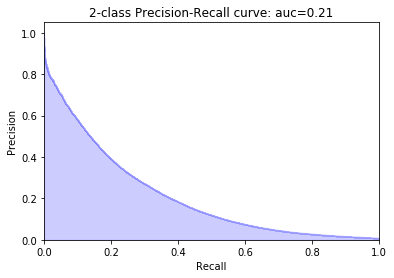

In [0]:
#ViZ!
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from inspect import signature
from sklearn.metrics import f1_score
from sklearn.metrics import auc
def plot_AUCPRC(labels, predictions):
	"""labels: a 1d list of all the labels (0 or 1) for our samples
		predictions: a 1d list of all the probabilities (between 0 and 1)
		             for each one of our samples. It should be the probability that
		             that this sample belongs to the second class (e.g a splice site.)
	"""
	# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument\
	precision, recall, _ = precision_recall_curve(labels, predictions)
	aucScore = auc(recall, precision)
	step_kwargs = ({'step': 'post'}
	               if 'step' in signature(plt.fill_between).parameters
	               else {})
	plt.step(recall, precision, color='b', alpha=0.2,
	         where='post')
	plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

	plt.xlabel('Recall')
	plt.ylabel('Precision')
	plt.ylim([0.0, 1.05])
	plt.xlim([0.0, 1.0])
	plt.title('2-class Precision-Recall curve: auc={0:0.2f}'.format(aucScore))
 
flat_preds = []
flat_labels = []
for i in range(len(labels)):
  p = xl_preds[i]
  l= labels[i][:len(p)]
  flat_preds.extend(p)
  flat_labels.extend(l)
print(flat_preds[:100])
plot_AUCPRC(flat_labels,flat_preds)